(3107,)
372
[167 167 167 ... 369 369 369]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 

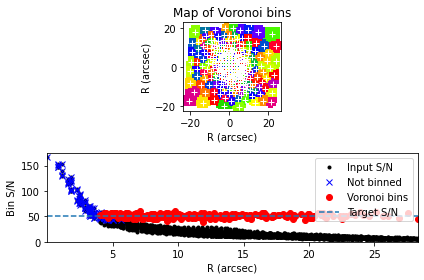

In [69]:
from os import path
import numpy as np
import matplotlib.pyplot as plt

import vorbin
from vorbin.voronoi_2d_binning import voronoi_2d_binning




#-----------------------------------------------------------------------------

def voronoi_binning_example():
    """
    Usage example for the procedure VORONOI_2D_BINNING.

    It is assumed below that the file voronoi_2d_binning_example.txt
    resides in the current directory. Here columns 1-4 of the text file
    contain respectively the x, y coordinates of each SAURON lens
    and the corresponding Signal and Noise.

    """
    file_dir = path.dirname(path.realpath(vorbin.__file__))  # path of vorbin
    x, y, signal, noise = np.loadtxt(file_dir + '/example/voronoi_2d_binning_example_input.txt').T
    target_sn = 50.0
    # Perform the actual computation. The vectors
    # (binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale)
    # are all generated in *output*
    #
    binNum, x_gen, y_gen, x_bar, y_bar, sn, nPixels, scale = voronoi_2d_binning(
        x, y, signal, noise, target_sn, plot=1, quiet=1)
    print(np.shape(binNum))
    print(len(np.unique(binNum)))
    print(binNum)
    print(np.unique(binNum))
    for i, inum in enumerate(np.unique(binNum)):
        print(i, inum)
    # print(x_gen)
    # Save to a text file the initial coordinates of each pixel together
    # with the corresponding bin number computed by this procedure.
    # binNum uniquely specifies the bins and for this reason it is the only
    # number required for any subsequent calculation on the bins.
    #
#     np.savetxt('voronoi_2d_binning_example_output.txt', np.column_stack([x, y, binNum]),
#                fmt=b'%10.6f %10.6f %8i')

#-----------------------------------------------------------------------------
    
if __name__ == '__main__':

    voronoi_binning_example()
    plt.tight_layout()
    # plt.pause(1)

In [60]:
np.meshgrid(np.arange(10), np.arange(10))
comb_array = np.array(np.meshgrid(np.arange(2), np.arange(3))).T.reshape(-1, 2)
s = np.array([[1, 2, 5], [3, 4, 8]])
n = np.array([[-1, -2, -5], [-3, -4, -8]])
sn_array = np.array([s, n]).T.reshape(-1, 2)
print(sn_array)
print(comb_array[:, 0])
print(comb_array[:, 1])


print(comb_array)
x = np.zeros((10, 4, 4))
x[0, 1, 2] = 2
print(np.shape(np.mean(x, axis=(0))))

[[ 1 -1]
 [ 3 -3]
 [ 2 -2]
 [ 4 -4]
 [ 5 -5]
 [ 8 -8]]
[0 0 0 1 1 1]
[0 1 2 0 1 2]
[[0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 1]
 [1 2]]
(4, 4)


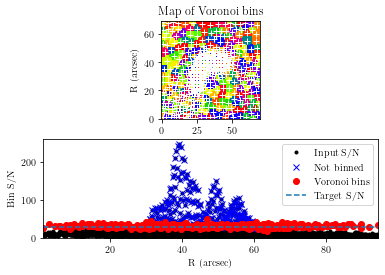

In [81]:
import os
import lmfit
import vorbin
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from astropy.table import Table
from matplotlib import rc
from vorbin.voronoi_2d_binning import voronoi_2d_binning
from PyAstronomy import pyasl
from mpdaf.obj import Cube, WCS, WaveCoord, iter_spe, iter_ima
rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
rc('text', usetex=True)


def getSigma_MUSE(wave):
    return (5.866e-8 * wave ** 2 - 9.187e-4 * wave + 6.04) / 2.355

def model_OII(wave_vac, z, sigma_kms, flux_OII, r_OII3729_3727, a, b):
    # Constants
    c_kms = 2.998e5
    wave_OII3727_vac = 3727.092
    wave_OII3729_vac = 3729.875

    wave_OII3727_obs = wave_OII3727_vac * (1 + z)
    wave_OII3729_obs = wave_OII3729_vac * (1 + z)

    sigma_OII3727_A = np.sqrt((sigma_kms / c_kms * wave_OII3727_obs) ** 2 + (getSigma_MUSE(wave_OII3727_obs)) ** 2)
    sigma_OII3729_A = np.sqrt((sigma_kms / c_kms * wave_OII3729_obs) ** 2 + (getSigma_MUSE(wave_OII3729_obs)) ** 2)

    flux_OII3727 = flux_OII / (1 + r_OII3729_3727)
    flux_OII3729 = flux_OII / (1 + 1.0 / r_OII3729_3727)

    peak_OII3727 = flux_OII3727 / np.sqrt(2 * sigma_OII3727_A ** 2 * np.pi)
    peak_OII3729 = flux_OII3729 / np.sqrt(2 * sigma_OII3729_A ** 2 * np.pi)

    OII3727_gaussian = peak_OII3727 * np.exp(-(wave_vac - wave_OII3727_obs) ** 2 / 2 / sigma_OII3727_A ** 2)
    OII3729_gaussian = peak_OII3729 * np.exp(-(wave_vac - wave_OII3729_obs) ** 2 / 2 / sigma_OII3729_A ** 2)

    return OII3727_gaussian + OII3729_gaussian + a * wave_vac + b


def model_Hbeta(wave_vac, z, sigma_kms, flux_Hbeta, a, b):
    # Constants
    c_kms = 2.998e5
    wave_Hbeta_vac = 4862.721

    wave_Hbeta_obs = wave_Hbeta_vac * (1 + z)
    sigma_Hbeta_A = np.sqrt((sigma_kms / c_kms * wave_Hbeta_obs) ** 2 + (getSigma_MUSE(wave_Hbeta_obs)) ** 2)

    peak_Hbeta = flux_Hbeta / np.sqrt(2 * sigma_Hbeta_A ** 2 * np.pi)
    Hbeta_gaussian = peak_Hbeta * np.exp(-(wave_vac - wave_Hbeta_obs) ** 2 / 2 / sigma_Hbeta_A ** 2)

    return Hbeta_gaussian + a * wave_vac + b


def model_OIII4960(wave_vac, z, sigma_kms, flux_OIII4960, a, b):
    # Constants
    c_kms = 2.998e5
    wave_OIII4960_vac = 4960.295

    wave_OIII4960_obs = wave_OIII4960_vac * (1 + z)
    sigma_OIII4960_A = np.sqrt((sigma_kms / c_kms * wave_OIII4960_obs) ** 2 + (getSigma_MUSE(wave_OIII4960_obs)) ** 2)

    peak_OIII4960 = flux_OIII4960 / np.sqrt(2 * sigma_OIII4960_A ** 2 * np.pi)
    OIII4960_gaussian = peak_OIII4960 * np.exp(-(wave_vac - wave_OIII4960_obs) ** 2 / 2 / sigma_OIII4960_A ** 2)

    return OIII4960_gaussian + a * wave_vac + b


def model_OIII5008(wave_vac, z, sigma_kms, flux_OIII5008, a, b):
    # Constants
    c_kms = 2.998e5
    wave_OIII5008_vac = 5008.239

    wave_OIII5008_obs = wave_OIII5008_vac * (1 + z)
    sigma_OIII5008_A = np.sqrt((sigma_kms / c_kms * wave_OIII5008_obs) ** 2 + (getSigma_MUSE(wave_OIII5008_obs)) ** 2)

    peak_OIII5008 = flux_OIII5008 / np.sqrt(2 * sigma_OIII5008_A ** 2 * np.pi)
    OIII5008_gaussian = peak_OIII5008 * np.exp(-(wave_vac - wave_OIII5008_obs) ** 2 / 2 / sigma_OIII5008_A ** 2)

    return OIII5008_gaussian + a * wave_vac + b


# def model_all(wave_vac, z, sigma_kms_OII, sigma_kms_Hbeta, sigma_kms_OIII4960, sigma_kms_OIII5008, flux_OII,
#               flux_Hbeta, flux_OIII4960, flux_OIII5008, r_OII3729_3727, a_OII, b_OII, a_Hbeta, b_Hbeta,
#               a_OIII4960, b_OIII4960, a_OIII5008, b_OIII5008):
def model_all(wave_vac, z, sigma_kms, flux_OII, flux_Hbeta, flux_OIII5008, r_OII3729_3727, a_OII, b_OII, a_Hbeta,
              b_Hbeta, a_OIII4960, b_OIII4960, a_OIII5008, b_OIII5008):

    m_OII = model_OII(wave_vac[0], z, sigma_kms, flux_OII, r_OII3729_3727, a_OII, b_OII)
    m_Hbeta = model_Hbeta(wave_vac[1], z, sigma_kms, flux_Hbeta, a_Hbeta, b_Hbeta)
    m_OIII4960 = model_OIII4960(wave_vac[2], z, sigma_kms, flux_OIII5008 / 3, a_OIII4960, b_OIII4960)
    m_OIII5008 = model_OIII5008(wave_vac[3], z, sigma_kms, flux_OIII5008, a_OIII5008, b_OIII5008)
    return np.hstack((m_OII, m_Hbeta, m_OIII4960, m_OIII5008))

# Fitting the narrow band image profile
path_cube_OII = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'CUBE_OII_line_offset.fits')
path_cube_Hbeta = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'CUBE_Hbeta_line_offset.fits')
path_cube_OIII4960 = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'CUBE_OIII_4960_line_offset.fits')
path_cube_OIII5008 = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'CUBE_OIII_5008_line_offset.fits')
cube_OII = Cube(path_cube_OII)
cube_Hbeta = Cube(path_cube_Hbeta)
cube_OIII4960 = Cube(path_cube_OIII4960)
cube_OIII5008 = Cube(path_cube_OIII5008)
cube_OII = cube_OII.subcube((80, 100), 70, unit_center=None, unit_size=None)
cube_Hbeta = cube_Hbeta.subcube((80, 100), 70, unit_center=None, unit_size=None)
cube_OIII4960 = cube_OIII4960.subcube((80, 100), 70, unit_center=None, unit_size=None)
cube_OIII5008 = cube_OIII5008.subcube((80, 100), 70, unit_center=None, unit_size=None)
cube_OIII5008[0, :, :].write('/Users/lzq/Dropbox/Data/CGM/image_OOHbeta_fitline.fits')

redshift_guess = 0.63
sigma_kms_guess = 150.0
# flux_OIII5008_guess = 0.01
r_OII3729_3727_guess = 2

parameters = lmfit.Parameters()
parameters.add_many(('z', redshift_guess, True, 0.62, 0.64, None),
                    ('sigma_kms', sigma_kms_guess, True, 10, 500, None),
                    ('flux_OII', 0.01, True, None, None, None),
                    ('flux_Hbeta', 0.02, True, None, None, None),
                    ('flux_OIII5008', 0.1, True, None, None, None),
                    ('r_OII3729_3727', r_OII3729_3727_guess, True, 0.2, None, None),
                    ('a_OII', 0.0, False, None, None, None),
                    ('b_OII', 0.0, False, None, None, None),
                    ('a_Hbeta', 0.0, False, None, None, None),
                    ('b_Hbeta', 0.0, False, None, None, None),
                    ('a_OIII4960', 0.0, False, None, None, None),
                    ('b_OIII4960', 0.0, False, None, None, None),
                    ('a_OIII5008', 0.0, False, None, None, None),
                    ('b_OIII5008', 0.0, False, None, None, None))


num_lines = 4
size = np.shape(cube_OII)[1]
fit_success = np.zeros((size, size))
r_fit, dr_fit = np.zeros((size, size)), np.zeros((size, size))
z_fit, dz_fit = np.zeros((size, size)), np.zeros((size, size))
sigma_fit, dsigma_fit = np.zeros((size, size)), np.zeros((size, size))
flux_fit, dflux_fit = np.zeros((3, size, size)), np.zeros((3, size, size))
a_fit, b_fit = np.zeros((num_lines, size, size)), np.zeros((num_lines, size, size))
da_fit, db_fit = np.zeros((num_lines, size, size)), np.zeros((num_lines, size, size))

#
wave_OII_vac = pyasl.airtovac2(cube_OII.wave.coord())
wave_Hbeta_vac = pyasl.airtovac2(cube_Hbeta.wave.coord())
wave_OIII4960_vac = pyasl.airtovac2(cube_OIII4960.wave.coord())
wave_OIII5008_vac = pyasl.airtovac2(cube_OIII5008.wave.coord())
wave_vac_all = np.array([wave_OII_vac, wave_Hbeta_vac, wave_OIII4960_vac, wave_OIII5008_vac], dtype=object)

# Data of each pixel
flux_OII, flux_Hbeta = cube_OII.data * 1e-3, cube_Hbeta.data * 1e-3
flux_OIII4960, flux_OIII5008 = cube_OIII4960.data * 1e-3, cube_OIII5008.data * 1e-3
flux_OII_err, flux_Hbeta_err = np.sqrt(cube_OII.var) * 1e-3, np.sqrt(cube_Hbeta.var) * 1e-3
flux_OIII4960_err = np.sqrt(cube_OIII4960.var) * 1e-3
flux_OIII5008_err = np.sqrt(cube_OIII5008.var) * 1e-3
flux_all = np.vstack((flux_OII, flux_Hbeta, flux_OIII4960, flux_OIII5008))
flux_err_all = np.vstack((flux_OII_err, flux_Hbeta_err, flux_OIII4960_err, flux_OIII5008_err))

# Voronoi binning
xy_array = np.array(np.meshgrid(np.arange(size), np.arange(size))).T.reshape(-1, 2)
signal, noise = np.max(flux_all, axis=0), np.mean(flux_err_all, axis=0)
sn_array = np.array([signal, noise]).T.reshape(-1, 2)
target_sn = 30
binNum, x_gen, y_gen, x_bar, y_bar, sn, nPixels, scale = \
    voronoi_2d_binning(xy_array[:, 0], xy_array[:, 1], sn_array[:, 0], sn_array[:, 1], target_sn, plot=1, quiet=1)


In [ ]:
import os
import aplpy
import numpy as np
import matplotlib as mpl
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import cm
from astropy import units as u
from muse_compare_z import compare_z
from matplotlib.colors import ListedColormap
from vorbin.voronoi_2d_binning import voronoi_2d_binning
rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})
rc('text', usetex=True)
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['ytick.major.size'] = 10

# Cmap
Blues = cm.get_cmap('Blues', 256)
Reds = cm.get_cmap('Reds', 256)
newcolors = Blues(np.linspace(0, 1, 256))
newcolors_red = Reds(np.linspace(0, 1, 256))
newcmp = ListedColormap(newcolors)

def ConvertFits(filename=None, table=None):
    path = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', filename + '.fits')
    data, hdr = fits.getdata(path, 1, header=True)
    
    
    fits.writeto('/Users/lzq/Dropbox/Data/CGM/' + filename + '_revised.fits', table, overwrite=True)
    data1, hdr1 = fits.getdata('/Users/lzq/Dropbox/Data/CGM/' + filename + '_revised.fits', 0, header=True)
    hdr1['BITPIX'], hdr1['NAXIS'], hdr1['NAXIS1'], hdr1['NAXIS2'] = hdr['BITPIX'], hdr['NAXIS'], \
                                                                    hdr['NAXIS1'], hdr['NAXIS2']
    hdr1['CRPIX1'], hdr1['CRPIX2'], hdr1['CTYPE1'], hdr1['CTYPE2'] = hdr['CRPIX1'], hdr['CRPIX2'], \
                                                                     hdr['CTYPE1'], hdr['CTYPE2']
    hdr1['CRVAL1'], hdr1['CRVAL2'], hdr1['LONPOLE'], hdr1['LATPOLE'] = hdr['CRVAL1'], hdr['CRVAL2'], \
                                                                       hdr['LONPOLE'], hdr['LATPOLE']
    hdr1['CSYER1'], hdr1['CSYER2'], hdr1['MJDREF'], hdr1['RADESYS'] = hdr['CSYER1'], hdr['CSYER2'], \
                                                                      hdr['MJDREF'], hdr['RADESYS']
    hdr1['CD1_1'], hdr1['CD1_2'], hdr1['CD2_1'], hdr1['CD2_2'] = hdr['CD1_1'], hdr['CD1_2'], hdr['CD2_1'], hdr['CD2_2']
    # Rescale the data by 1e17
    fits.writeto('/Users/lzq/Dropbox/Data/CGM/' + filename + '_revised.fits', data1, hdr1, overwrite=True)
    
    

def PlotMap(line='OIII', check=False, test=True, snr_thr=3, row=None, z=None, ra=None, dec=None):
    # Load OIII
    if test is True:
        path_fit_info = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM',
                                     'fit' + line + '_info_test.fits')
        path_fit_info_err = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM',
                                         'fit' + line + '_info_err_test.fits')
    else:
        path_fit_info = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM',
                                     'fit' + line + '_info.fits')
        path_fit_info_err = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM',
                                         'fit' + line + '_info_err.fits')
    fit_info = fits.getdata(path_fit_info, 0, ignore_missing_end=True)
    fit_info_err = fits.getdata(path_fit_info_err, 0, ignore_missing_end=True)

    if line == 'OOHbeta':
        # [z_fit, r_fit, sigma_fit_OII, sigma_fit_Hbeta, sigma_fit_OIII4960, sigma_fit_OIII5008,
        #  flux_fit_OII, flux_fit_Hbeta, flux_fit_OIII4960, flux_fit_OIII5008, a_fit_OII, a_fit_Hbeta,
        #  a_fit_OIII4960, a_fit_OIII5008, b_fit_OII, b_fit_Hbeta, b_fit_OIII4960, b_fit_OIII5008] = fit_info
        # [dz_fit, dr_fit, dsigma_fit_OII, dsigma_fit_Hbeta, dsigma_fit_OIII4960, dsigma_fit_OIII5008,
        #  dflux_fit_OII, dflux_fit_Hbeta, dflux_fit_OIII4960, dflux_fit_OIII5008, da_fit_OII, da_fit_Hbeta,
        #  da_fit_OIII4960, da_fit_OIII5008, db_fit_OII, db_fit_Hbeta, db_fit_OIII4960, db_fit_OIII5008] = fit_info_err

        [z_fit, r_fit, fit_success, sigma_fit, flux_fit_OII, flux_fit_Hbeta, flux_fit_OIII5008, a_fit_OII, a_fit_Hbeta,
         a_fit_OIII4960, a_fit_OIII5008, b_fit_OII, b_fit_Hbeta, b_fit_OIII4960, b_fit_OIII5008] = fit_info
        [dz_fit, dr_fit, dsigma_fit, dflux_fit_OII, dflux_fit_Hbeta, dflux_fit_OIII5008, da_fit_OII, da_fit_Hbeta,
         da_fit_OIII4960, da_fit_OIII5008, db_fit_OII, db_fit_Hbeta, db_fit_OIII4960, db_fit_OIII5008] = fit_info_err
    elif line == 'OII':
        [z_fit, sigma_fit, flux_fit, fit_success, r_fit, a_fit, b_fit] = fit_info
        [dz_fit, dsigma_fit, dflux_fit, dr_fit, da_fit, db_fit] = fit_info_err
    else:
    # Load data
        [z_fit, sigma_fit, flux_fit, fit_success, a_fit, b_fit] = fit_info
        [dz_fit, dsigma_fit, dflux_fit, da_fit, db_fit] = fit_info_err
    z_qso = 0.6282144177077355
    v_fit = 3e5 * (z_fit - z_qso) / (1 + z_qso)
    v_gal = 3e5 * (z - z_qso) / (1 + z_qso)
    
    x, y = 
    signal, noise = 
    target_sn
    binNum, x_gen, y_gen, x_bar, y_bar, sn, nPixels, scale = voronoi_2d_binning(
        x, y, signal, noise, target_sn, plot=1, quiet=0)
        
    # Check consistency
    if check is True:
        plt.figure(figsize=(8, 8), dpi=300)
        plt.imshow(v_fit, cmap='coolwarm', vmin=-300, vmax=300, origin='lower')
        plt.show()

    if line == 'OOHbeta':
        flux_stack = np.stack((flux_fit_OII, flux_fit_Hbeta, flux_fit_OIII5008), axis=0)
        dflux_stack = np.stack((dflux_fit_OII, dflux_fit_Hbeta, dflux_fit_OIII5008), axis=0)
        fit_max = np.amax(flux_stack / dflux_stack, axis=0)
        v_fit = np.where((fit_max > snr_thr), v_fit, np.nan)
        ConvertFits(filename='image_' + line + '_fitline', table=v_fit)

    else:
        # Final data
        v_fit = np.where((flux_fit / dflux_fit > snr_thr), v_fit, np.nan)
        ConvertFits(filename='image_' + line + '_fitline', table=v_fit)

    # Plot
    fig = plt.figure(figsize=(8, 8), dpi=300)
    path_dv = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'Data', 'CGM', 'image_' + line + '_fitline_revised.fits')
    gc = aplpy.FITSFigure(path_dv, figure=fig, north=True)
    gc.set_system_latex(True)
    gc.show_colorscale(vmin=-300, vmax=300, cmap='coolwarm')
    gc.add_colorbar()
    gc.ticks.set_length(30)
    gc.show_markers(40.1359, -18.8643, facecolors='none', marker='*', c='none', edgecolors='k', linewidths=0.5, s=250)
    gc.show_markers(ra, dec, facecolor='none', marker='o', c='none', edgecolors='k', linewidths=0.8, s=100)
    gc.show_markers(ra, dec, marker='o', c=v_gal, linewidths=0.5, s=40, vmin=-300, vmax=300, cmap='coolwarm')
    # gc.show_regions('/Users/lzq/Dropbox/Data/CGM/galaxy_list.reg')
    gc.colorbar.set_location('bottom')
    gc.colorbar.set_pad(0.)
    gc.colorbar.set_axis_label_text(r'$\mathrm{\Delta v \; [km \, s^{-1}]}$')
    gc.colorbar.set_font(size=15)
    gc.colorbar.set_axis_label_font(size=15)
    gc.add_scalebar(length=15 * u.arcsecond)
    gc.scalebar.set_corner('top left')
    gc.scalebar.set_label(r"$15'' \approx 100 \mathrm{\; pkpc}$")
    gc.scalebar.set_font_size(15)
    gc.ticks.hide()
    gc.tick_labels.hide()
    gc.axis_labels.hide()

    for i in range(len(row)):
        gc.add_label(ra[i] + 0.00014, dec[i] - 0.00008, "{0:.0f}".format(v_gal[i]), size=10, horizontalalignment='right'
                     , verticalalignment='bottom')
    # label
    if line == 'OIII':
        gc.add_label(0.80, 0.97, r'$\Delta v = v_{\mathrm{[O \, III]}} - v_{\mathrm{qso}}$', size=15, relative=True)
    elif line == 'OII':
        gc.add_label(0.80, 0.97, r'$\Delta v = v_{\mathrm{[O \, II]}} - v_{\mathrm{qso}}$', size=15, relative=True)
    elif line == 'OOHbeta':
        gc.add_label(0.80, 0.97, r'$\Delta v = v_{\mathrm{[OOH \beta]}} - v_{\mathrm{qso}}$', size=15, relative=True)
    xw, yw = gc.pixel2world(195, 150)
    gc.show_arrows(xw, yw, -0.00005 * yw, 0, color='k')
    gc.show_arrows(xw, yw, 0, -0.00005 * yw, color='k')
    gc.add_label(0.9775, 0.85, r'N', size=15, relative=True)
    gc.add_label(0.88, 0.75, r'E', size=15, relative=True)
    fig.savefig('/Users/lzq/Dropbox/Data/CGM_plots/' + line + '_dv_map.png', bbox_inches='tight')


# Load galxies infomation
ggp_info = compare_z(cat_sean='ESO_DEEP_offset_zapped_objects_sean.fits',
                     cat_will='ESO_DEEP_offset_zapped_objects.fits')
row_final = ggp_info[1]
ID_final = ggp_info[2]
z_final = ggp_info[3]
name_final = ggp_info[5]
ra_final = ggp_info[7]
dec_final = ggp_info[8]

col_ID = np.arange(len(row_final))
select_array = np.sort(np.array([6, 7, 181, 182, 80, 81, 82, 179, 4, 5, 64]))
select_gal = np.in1d(row_final, select_array)
row_final = row_final[select_gal]
z_final = z_final[select_gal]
ra_final = ra_final[select_gal]
dec_final = dec_final[select_gal]

# run
# PlotMap(line='OII', check=False, snr_thr=2.5, row=row_final, z=z_final, ra=ra_final, dec=dec_final)
# PlotMap(line='OIII', snr_thr=3, row=row_final, z=z_final, ra=ra_final, dec=dec_final)
PlotMap(line='OOHbeta', snr_thr=4, check=True, row=row_final, z=z_final, ra=ra_final, dec=dec_final)
    
